In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.circuit import ParameterVector

In [4]:
# Load X data of dimension Nv x 4(including color)
import os
import pandas as pd
v = pd.read_csv('hits_and_tracks_3d_events_all.csv', sep=';')
print("features data loaded...")

features data loaded...


In [9]:
v.head(3)

,event_id,sub_detector_id,sub_detector_type,track_id,track_type,radial_const,azimuthal_const,pitch_const,radial_coeff,azimuthal_coeff,pitch_coeff,hit_id,hit_r,hit_theta,hit_z
0,0,1,short_strip,0,helical_expanding,0.040474,1.797689,0.005237,0.250489,-1,-0.718796,0,0.747227,5.284354,-1.983446
1,0,3,short_strip,0,helical_expanding,0.040474,1.797689,0.005237,0.250489,-1,-0.718796,1,1.077888,3.871574,-2.997883
2,0,5,short_strip,0,helical_expanding,0.040474,1.797689,0.005237,0.250489,-1,-0.718796,2,1.436187,2.486336,-3.979522


In [10]:
rows_with_event_id_zero = v[v['event_id'] == 0]

In [12]:
new_df=rows_with_event_id_zero[['hit_id','hit_r','hit_theta','hit_z']]

In [14]:
new_df.set_index('hit_id',inplace=True)

In [17]:
new_df['hit_x']=new_df['hit_r']*np.sin(new_df['hit_theta'])
new_df['hit_y']=new_df['hit_r']*np.cos(new_df['hit_theta'])
new_df=new_df[['hit_x','hit_y','hit_z']]
new_df

<ipython-input-17-90f79e2eaeec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['hit_x']=new_df['hit_r']*np.sin(new_df['hit_theta'])
<ipython-input-17-90f79e2eaeec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['hit_y']=new_df['hit_r']*np.cos(new_df['hit_theta'])


,hit_x,hit_y,hit_z
hit_id,,,
0,-0.628298,0.404463,-1.983446
1,-0.718796,-0.803228,-2.997883
2,0.875159,-1.138740,-3.979522
3,1.617943,0.740712,-5.019919
4,-0.636256,2.033484,-6.029640
5,-2.469909,-0.208080,-7.031078
6,-0.351125,-2.810445,-7.993486
7,3.084340,-0.791833,-8.974554
8,1.506305,3.196817,-10.012223


In [25]:
#Reduced adjacency matrix A
cut=5
#A[i][j]==1 implies there is an edge between i, j-th nodes.
A=[[0 for _ in range(cut)] for _ in range(cut)]
#Collect edges with its end in the "cut" bound
for i in range(4):
    A[i][i+1]=1
print("Adjacency matrix prepared...")

Adjacency matrix prepared...


In [33]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
# Reduced colored X data
raw_data=new_df[:cut].values
# Create a quantum circuit with Nv qubits
Nv = len(raw_data)
num_qubits = Nv * 3  # 3 qubits per row (x,y,z)
# Initialize a quantum circuit
import math
qc = QuantumCircuit(num_qubits)
#feature = np.random.random(size=(cut*3))
feature = []
for i in range(num_qubits):
    feature.append(Parameter('phi_{}'.format(i)))
# Encode each feature value into a qubit 
for i in range(Nv):
    for j in range(3):
        if j==0:
            qc.rx(feature[i*3+j], i * 3+j)
        elif j==1:
            qc.ry(feature[i*3+j], i * 3+j)
        else:
            qc.rz(feature[i*3+j], i * 3+j)
    #Entangle 3 positions
    qc.cx(i * 3, i * 3 + 1)
    qc.cx(i * 3 + 1, i * 3 + 2)
    qc.cx(i * 3 + 2, i * 3)
# Encode each feature value into a qubit 
print("All 3 features encoded in QC...")

All 3 features encoded in QC...


In [34]:
# Define a list of trainable parameters for the entanglement
num_params = len(A)  # Number of trainable parameters for the entanglement
ansatz = []
for i in range(num_params):
    ansatz.append(Parameter('theta_{}'.format(i)))
print("Entangling qubits using fake adjacency matrix...")
# Apply trainable entanglement gates based on adjacency matrix A
for i in range(len(A)):
    qc.ry(ansatz[i],i*3)
for i in range(len(A)):
    for j in range(i + 1, len(A)):
        if A[i][j] == 1:
            # Use trainable parameters for entanglement angles
            qc.cx(i * 3, j * 3)
print("Parameterized quantum circuit ready...")

Entangling qubits using fake adjacency matrix...
Parameterized quantum circuit ready...


In [35]:
# Add measurement operations based on adjacency matrix A
look = [0 for _ in range(len(A))]
for i in range(len(A)):
    for j in range(i + 1, len(A)):
        if A[i][j] == 1:
            look[j]=1
#Edge info is collected in look
#Would like to compare it with QNN output
print("Compare Y with the following positions..")
print(look)

Compare Y with the following positions..
[0, 1, 1, 1, 1]


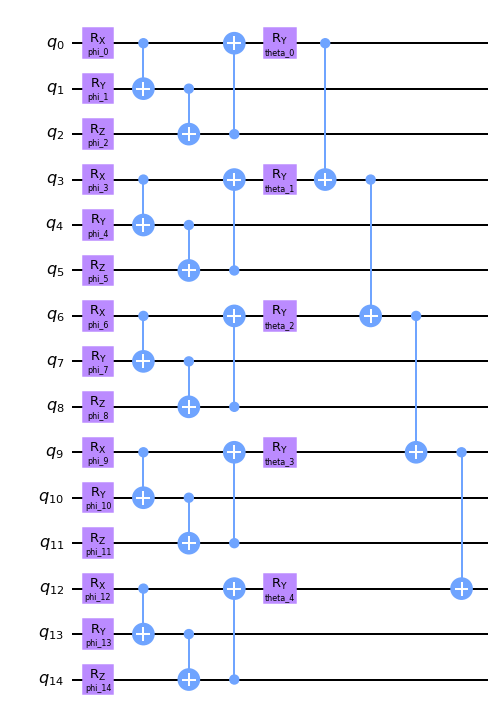

In [36]:
from qiskit import transpile
# Transpile the circuit for execution
simulator = Aer.get_backend('qasm_simulator')
full_circuit = transpile(qc, simulator)
# Visualize the transpiled circuit
full_circuit.draw(output='mpl')

In [37]:
#Implement quantum neural network
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
#Custom interpreter for our purpose:
#Create size Ne binary string
def custom_interpret(x):
    binary_str="{:b}".format(x)
    slice_length = len(binary_str) // Nv
    results = 0
    for i in range(Nv):
        s, e = i * slice_length, (i + 1) * slice_length
        #Chop up the binary string into Nv pieces
        slice_binary = binary_str[s:e]
        #Collect information for each piece
        parity = slice_binary.count("1") % 2
        #Form an integer using the bits
        results+=(parity*2**i)
    return results
# construct QNN
inp=np.random.random(size=(cut*3))
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=inp,
    weight_params=ansatz,
    interpret = custom_interpret,
    #Output shape is 2^(number of qubits)
    output_shape = 2**Nv
)

In [39]:
flat_raw_data

array([-0.6282976 ,  0.40446345, -1.98344629, -0.71879567, -0.80322845,
       -2.99788282,  0.87515937, -1.13874032, -3.97952187,  1.61794297,
        0.7407116 , -5.01991945, -0.63625601,  2.0334843 , -6.02964045])

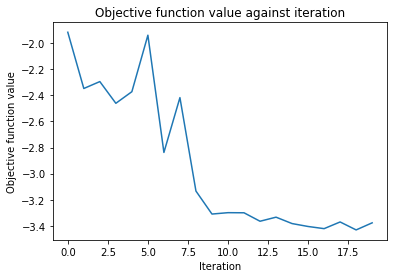

Fitted!


In [43]:
# Callback function to plot the loss
from IPython.display import clear_output
#Set the same label for all 3 qubits in a single node
def expand_y(y):
    n=len(y)
    Y=[0 for _ in range(3*n)]
    for i in range(n):
        for j in range(3):
            Y[3*i+j]=y[i]
    return np.array(Y)
objective_func_vals = []
#Loss graph to track the training
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
def simple_callback(weights,obj_func_eval):
    print("training...","current loss is...",obj_func_eval)
# Create a neural network classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,optimizer=COBYLA(maxiter=20),
    loss='cross_entropy',callback=callback_graph)
Y = [0,1,1,1,1]  # True edge labels of dimension
y = expand_y(Y)
flat_raw_data=raw_data.flatten()
# Train the classifier using the encoded quantum circuits and labels
sampler_classifier.fit(flat_raw_data, y)
print("Fitted!")

In [44]:
# It's supposed to produce something like 
# look='101000'
def intTobit(arr):
    n=arr[0]
    st=''
    while n>0:
        n,q=divmod(n,2)
        st+=str(q)
    if len(st)<Nv:
        st+='0'
    return st[::-1]
print("Compare ",intTobit(sampler_classifier.predict(flat_raw_data)),
      " with ",Y," in the following position ",look)

Compare  10101  with  [0, 1, 1, 1, 1]  in the following position  [0, 1, 1, 1, 1]
